In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from matplotlib import image as Image
from skimage import transform as Transform
from utils import readRegistrationParamsFromHDF5, rotationMatrixToEulerAngles, readToothRowScalesFromHDF5, getRotMats, getRotMat, getRotAngles, showPointCloud

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
NUM_POINT = 1500
PG_SHAPE = (NUM_POINT, 3)
SHIFT_VEC = np.array([0.,10.,0.])
NUM_TOOTH = 28
NUM_PC = 50
INPUT_SHAPE = (512, 512, 15)
SSM_DIR = r"./data/cpdAlignedData/eigValVec/"
SRC_DIR = r"./dataWithPhoto/cpdAlignedData/"
PARAM_DIR = r"./dataWithPhoto/params/"
NAME_ID_MAPPING_CSV = r"./dataWithPhoto/nameIndexMapping.csv"
UPPER_INDICES = [11,12,13,14,15,16,17,21,22,23,24,25,26,27] #不考虑智齿18,28
LOWER_INDICES = [31,32,33,34,35,36,37,41,42,43,44,45,46,47] #不考虑智齿38,48

In [4]:
def __getToothIndex(f):
    return int(os.path.basename(f).split(".")[0].split("_")[-1])

def loadMuEigValSigma(ssmDir, numPC=NUM_PC):
    """Mu.shape=(28,1500,3), sqrtEigVals.shape=(28,1,100), Sigma.shape=(28,4500,100)"""
    muNpys = glob.glob(os.path.join(ssmDir,"meanAlignedPG_*.npy"))
    muNpys = sorted(muNpys, key=lambda x:__getToothIndex(x))
    Mu = np.array([np.load(x) for x in muNpys])
    eigValNpys = glob.glob(os.path.join(ssmDir,"eigVal_*.npy"))
    eigValNpys = sorted(eigValNpys, key=lambda x:__getToothIndex(x))
    sqrtEigVals = np.sqrt(np.array([np.load(x) for x in eigValNpys]))
    eigVecNpys = glob.glob(os.path.join(ssmDir,"eigVec_*.npy"))
    eigVecNpys = sorted(eigVecNpys, key=lambda x:__getToothIndex(x))
    Sigma = np.array([np.load(x) for x in eigVecNpys])
    return Mu, sqrtEigVals[:,np.newaxis,:numPC], Sigma[...,:numPC]

def loadInvRegistrationParams(loadDir):
    """生成DataFrame,含有逆配准参数s,R,transVec,transVecShift"""
    """initPG = np.multiply(s, np.matmul(PG+transVec, R)) + transVecShift"""
    toothIndices = UPPER_INDICES + LOWER_INDICES
    paramDF = pd.DataFrame(columns=["tag"])
    # 下牙列逆配准参数
    tags, rowScales, transVecShifts = readToothRowScalesFromHDF5(os.path.join(loadDir, "scalesOfLowerToothRow.hdf5"), "L")
    indexTag = [int(tag[:-1]) for tag in tags]
    invScales = [1./s for s in rowScales]
    invTransVecShifts = -transVecShifts
    tempDF = pd.DataFrame({"tag":indexTag,"lower_s":list(invScales), "lower_ts":list(invTransVecShifts)})
    paramDF = paramDF.merge(tempDF, how="outer", on="tag")
    # 上牙列逆配准参数
    tags, rowScales, transVecShifts = readToothRowScalesFromHDF5(os.path.join(loadDir, "scalesOfUpperToothRow.hdf5"), "U")
    indexTag = [int(tag[:-1]) for tag in tags]
    invScales = [1./s for s in rowScales]
    invTransVecShifts = -transVecShifts
    tempDF = pd.DataFrame({"tag":indexTag,"upper_s":list(invScales), "upper_ts":list(invTransVecShifts)})
    paramDF = paramDF.merge(tempDF, how="outer", on="tag")
    # 牙齿统计形状逆配准参数
    for i in toothIndices:
        h5File = os.path.join(loadDir, "sRtParams_{}.hdf5".format(i))
        tags, scales, rotMats, transVecs = readRegistrationParamsFromHDF5(h5File, i)
        indexTag = [int(tag[:-1]) for tag in tags]
        invRotAngles = [rotationMatrixToEulerAngles(r.T) for r in rotMats]
        invScales = 1./scales
        invTransVecs = -transVecs
        tempDF = pd.DataFrame({"tag":indexTag,"{}s".format(i):list(invScales), "{}rxyz".format(i):list(invRotAngles),"{}txyz".format(i):list(invTransVecs)})
        paramDF = paramDF.merge(tempDF, how="outer", on="tag")
    sUpperColumns = ["{}s".format(id) for id in UPPER_INDICES]
    sLowerColumns = ["{}s".format(id) for id in LOWER_INDICES]
    paramDF = paramDF[~paramDF[sUpperColumns].isna().all(axis=1)]
    paramDF = paramDF[~paramDF[sLowerColumns].isna().all(axis=1)] # 删除缺少上牙列或下牙列的数据
    paramDF = paramDF.sort_values(by="tag", ignore_index=True)
    return paramDF

def loadAlignedTeethPgWithMaskByIndex(index, pgShape=(1500,3), srcRootDir="./dataWithPhoto/cpdAlignedData"):
    pgTxts = [os.path.join(srcRootDir, str(tID), "{}U.txt".format(index)) for tID in UPPER_INDICES]
    pgTxts.extend([os.path.join(srcRootDir, str(tID), "{}L.txt".format(index)) for tID in LOWER_INDICES])
    masks = [os.path.exists(f) for f in pgTxts]
    PGs = [np.loadtxt(f) if mask==True else np.zeros(pgShape) for f,mask in zip(pgTxts,masks)]
    return np.array(masks), np.array(PGs)

def getScalesRxyzTxyzRotMats(invParamDF, index):
    """计算s,rxyz,txyz,rotMats (nan用0填充)
    txyz = np.multiply(s, np.matmul(transVec, rotMats)) + transVecShift"""
    sColumns = ["{}s".format(id) for id in UPPER_INDICES+LOWER_INDICES]
    rxyzColumns = ["{}rxyz".format(id) for id in UPPER_INDICES+LOWER_INDICES]
    postTxyzColumns = ["{}txyz".format(id) for id in UPPER_INDICES+LOWER_INDICES]
    indexedRow = invParamDF[invParamDF["tag"]==index]
    
    scaleList = indexedRow[sColumns].values.flatten().tolist()
    scales = [s if not np.isnan(s) else 0. for s in scaleList]
    scales = np.array(scales)[:,np.newaxis,np.newaxis]
    
    rxyzList = indexedRow[rxyzColumns].values.flatten().tolist()
    rxyzs = [rxyz if not np.isnan(rxyz).any() else np.zeros((3,)) for rxyz in rxyzList]
    rotMats = [getRotMat(rxyz) if not np.isnan(rxyz).any() else np.zeros((3,3)) for rxyz in rxyzList]
    
    postTxyzList = indexedRow[postTxyzColumns].values.flatten().tolist()
    transVecs = [txyz if not np.isnan(txyz).any() else np.zeros((3,)) for txyz in postTxyzList]
    transVecShifts = np.vstack([indexedRow["upper_ts"].values[0],indexedRow["lower_ts"].values[0]])
    transVecShifts = np.nan_to_num(transVecShifts, nan=0.0)
    txyzs = np.multiply(scales, np.matmul(np.array(transVecs)[:,np.newaxis,:], np.array(rotMats))) + np.array(transVecShifts)[:,np.newaxis,:]
    
    return scales, np.array(rxyzs), np.array(txyzs), np.array(rotMats)

def loadDataSet(paramDF, Mu, Sigma, pgShape=PG_SHAPE, srcRootDir=SRC_DIR):
    Y_mask = [] # shape=(None,28,1,1)
    Y_scale = [] # shape=(None,28,1,1)
    Y_rxyz = [] # shape=(None,28,3)
    Y_txyz = [] # shape=(None,28,1,3)
    Y_fVec = [] # shape=(None,28,1,NUM_PC)
    X_pg = [] # shape=(None,28,1500,3)
    for i,index in enumerate(paramDF["tag"].values):
        mask, alignedPG = loadAlignedTeethPgWithMaskByIndex(index, pgShape, srcRootDir)
        mask = mask.reshape(-1,1,1)
        fVec = np.matmul((alignedPG - Mu).reshape(Mu.shape[0], 1, Mu.shape[1]*Mu.shape[2]), Sigma)
        scale, rxyz, txyz, rotMat = getScalesRxyzTxyzRotMats(paramDF, index)
        PG = np.multiply(mask, np.multiply(np.matmul(alignedPG, rotMat), scale) + txyz)
        Y_mask.append(mask)
        Y_scale.append(scale)
        Y_rxyz.append(rxyz)
        Y_txyz.append(txyz)
        Y_fVec.append(fVec)
        X_pg.append(PG)
        print("Load {}/{}".format(i+1,len(paramDF["tag"].values)))
    return X_pg, Y_mask, Y_scale, Y_rxyz, Y_txyz, Y_fVec

In [5]:
Mu, sqrtEigVals, Sigma = loadMuEigValSigma(SSM_DIR, numPC=NUM_PC)

In [6]:
invRegistrationParamDF = loadInvRegistrationParams(loadDir=PARAM_DIR)

In [7]:
# Y_pg, X_mask, Y_scale, Y_rxyz, Y_txyz, Y_fVec = loadDataSet(invRegistrationParamDF, Mu, Sigma, pgShape=PG_SHAPE, srcRootDir=SRC_DIR)

In [8]:
tempSaveDir = r"./res-2D-3D/"
if not os.path.exists(tempSaveDir):
    os.makedirs(tempSaveDir)
Y_pg_npy = os.path.join(tempSaveDir, "Y_pg.npy")
X_mask_npy = os.path.join(tempSaveDir, "X_mask.npy")
# np.save(Y_pg_npy, np.array(Y_pg))
# np.save(X_mask_npy, np.array(X_mask))

In [9]:
def shiftUpperLowerToothRow(X_pg, shiftVec=SHIFT_VEC):
    shifted_X_pg = []
    for pg,mask in zip(X_pg,X_mask):
        shifted_pg = np.concatenate([pg[:pg.shape[0]//2, ...]+shiftVec, pg[pg.shape[0]//2:, ...]-shiftVec], axis=0)
        shifted_X_pg.append(shifted_pg)
    return shifted_X_pg

In [10]:
X_mask = np.load(X_mask_npy)
Y_pg = np.load(Y_pg_npy)
shifted_Y_pg = shiftUpperLowerToothRow(Y_pg, shiftVec=SHIFT_VEC)

In [11]:
infoDF = pd.read_csv(NAME_ID_MAPPING_CSV)
infoDF.rename({"tag":"nameTag","index":"tag"}, axis=1, inplace=True, errors="raise")

In [12]:
def loadPhotos(orderedTagList, infoDF, shape):
    lowerPhotos = []
    upperPhotos = []
    leftPhotos = []
    rightPhotos = []
    frontalPhotos = []
    for tag in orderedTagList:
        loF,upF,leF,riF,frF = infoDF.loc[infoDF["tag"]==tag, ["lowerPhoto","upperPhoto","leftPhoto","rightPhoto","frontalPhoto"]].values[0]
        loPh = Image.imread(loF)
        upPh = Image.imread(upF)
        lePh = Image.imread(leF)
        riPh = Image.imread(riF)
        frPh = Image.imread(frF)
        lowerPhotos.append(Transform.resize(loPh, shape))
        upperPhotos.append(Transform.resize(upPh, shape))
        leftPhotos.append(Transform.resize(lePh, shape))
        rightPhotos.append(Transform.resize(riPh, shape))
        frontalPhotos.append(Transform.resize(frPh, shape))
    return lowerPhotos, upperPhotos, leftPhotos, rightPhotos, frontalPhotos

In [13]:
# lowerPhotos, upperPhotos, leftPhotos, rightPhotos, frontalPhotos = loadPhotos(orderedTagList=invRegistrationParamDF["tag"].values, infoDF=infoDF, shape=INPUT_SHAPE)

In [14]:
def getImageNamesList(orderedTagList, infoDF):
    imageNamesList = []
    for tag in orderedTagList:
        imageNames = infoDF.loc[infoDF["tag"]==tag, ["lowerPhoto","upperPhoto","leftPhoto","rightPhoto","frontalPhoto"]].values[0]
        imageNamesList.append(imageNames)
    return imageNamesList

In [15]:
imageNamesList = getImageNamesList(orderedTagList=invRegistrationParamDF["tag"].values, infoDF=infoDF)

In [16]:
def split_train_test_data(Y_pg, X_mask, X_imageNames, train_ratio=0.8):
    num = len(Y_pg)
    indices = list(range(num))
    np.random.shuffle(indices)
    train = indices[:int(num*train_ratio)]
    test = indices[int(num*train_ratio):]
    return np.array(Y_pg)[train], np.array(X_mask)[train], np.array(X_imageNames)[train], np.array(Y_pg)[test], np.array(X_mask)[test], np.array(X_imageNames)[test] 

In [17]:
Y_pg_tr, X_mask_tr, X_imageNames_tr, Y_pg_tes, X_mask_tes, X_imageNames_tes = split_train_test_data(shifted_Y_pg, X_mask, imageNamesList, train_ratio=0.8)

In [18]:
# class DataGenerator(keras.utils.Sequence):
#     def __init__(self, image_names_list, mask_list, pg_list, batch_size=1, train=True):
#         self.batch_size = batch_size
#         self.pg_list = pg_list
#         self.mask_list = mask_list
#         self.image_names_list = image_names_list
#         self.train = train
#         self.index_cnt = len(pg_list)
#         self.index_list = list(range(self.index_cnt))
#         self.on_epoch_end()
#     def __len__(self):
#         return self.index_cnt // self.batch_size
#     def __getitem__(self, k):
#         ks = k * self.batch_size
#         kt = ks + self.batch_size
#         x_images = np.empty((self.batch_size, *INPUT_SHAPE), dtype='float32')  # (None,512,512,15)
#         x_masks = np.empty((self.batch_size, NUM_TOOTH, 1, 1), dtype='float32')
#         y_pgs = np.empty((self.batch_size, NUM_TOOTH, NUM_POINT, 3), dtype='float32')
#         for i, index in enumerate(range(ks, kt)):
#             real_index = self.index_list[index]
#             imageNames = self.image_names_list[real_index]
#             rawImages = [self.generate_image(imageFile, maxRotAngle=10) for imageFile in imageNames]
#             x_image = np.concatenate(rawImages, axis=-1)
#             x_images[i] = x_image
#             x_masks[i] = self.mask_list[real_index]
#             y_pgs[i] = self.pg_list[real_index]
            
#         return [x_images,x_masks], y_pgs
#     def on_epoch_end(self):
#         if self.train == True:
#             np.random.shuffle(self.index_list)
#     def generate_image(self, imageFile, maxRotAngle=10):
#         image = Image.imread(imageFile)
#         if self.train == True:
#             theta = maxRotAngle * np.random.rand()
#             image = Transform.rotate(image, theta)
#         image = Transform.resize(image, (*INPUT_SHAPE[:2],3)) 
#         return image


INPUT_SHAPE = (512,512,3)
class DataGenerator(keras.utils.Sequence):
    def __init__(self, image_names_list, mask_list, pg_list, batch_size=1, train=True):
        self.batch_size = batch_size
        self.pg_list = pg_list
        self.mask_list = mask_list
        self.image_names_list = image_names_list
        self.train = train
        self.index_cnt = len(pg_list)
        self.index_list = list(range(self.index_cnt))
        self.on_epoch_end()
    def __len__(self):
        return self.index_cnt // self.batch_size
    def __getitem__(self, k):
        ks = k * self.batch_size
        kt = ks + self.batch_size
        x1 = np.empty((self.batch_size, *INPUT_SHAPE), dtype='float32')  # lower:(None,512,512,3)
        x2 = np.empty((self.batch_size, *INPUT_SHAPE), dtype='float32')  # upper:(None,512,512,3)
        x3 = np.empty((self.batch_size, *INPUT_SHAPE), dtype='float32')  # left:(None,512,512,3)
        x4 = np.empty((self.batch_size, *INPUT_SHAPE), dtype='float32')  # right:(None,512,512,3)
        x5 = np.empty((self.batch_size, *INPUT_SHAPE), dtype='float32')  # frontal:(None,512,512,3)
        x_masks = np.empty((self.batch_size, NUM_TOOTH, 1, 1), dtype='float32')
        y_pgs = np.empty((self.batch_size, NUM_TOOTH, NUM_POINT, 3), dtype='float32')
        for i, index in enumerate(range(ks, kt)):
            real_index = self.index_list[index]
            imageNames = self.image_names_list[real_index]
            rawImages = [self.generate_image(imageFile, maxRotAngle=10) for imageFile in imageNames]
            x1[i], x2[i], x3[i], x4[i], x5[i] = rawImages
            x_masks[i] = self.mask_list[real_index]
            y_pgs[i] = self.pg_list[real_index]
            
        return [x1,x2,x3,x4,x5,x_masks], y_pgs
    def on_epoch_end(self):
        if self.train == True:
            np.random.shuffle(self.index_list)
    def generate_image(self, imageFile, maxRotAngle=10):
        image = Image.imread(imageFile)
        if self.train == True:
            theta = maxRotAngle * np.random.rand()
            image = Transform.rotate(image, theta)
        image = Transform.resize(image, INPUT_SHAPE) 
        return image
        
    

In [23]:
batch_size = 2
train_dg = DataGenerator(X_imageNames_tr, X_mask_tr, Y_pg_tr, batch_size, True)
valid_dg = DataGenerator(X_imageNames_tes, X_mask_tes, Y_pg_tes, batch_size, False)

In [24]:
def leakyDense(x, filters, leaky_rate=.1, **kwargs):
    x = layers.Dense(filters, **kwargs)(x)
    x = layers.LeakyReLU(leaky_rate)(x)
    return x
def LeakyConv2D(x, filters, k_size, leaky_rate=.1, dila=1):
    x = layers.Conv2D(filters, kernel_size=k_size, dilation_rate=dila, padding='same')(x)
    x = layers.LeakyReLU(leaky_rate)(x)
    return x
def MultiConv2D(x, filters, k_size, conv_times, dial=1, leaky_rate=.1):
    x = LeakyConv2D(x, filters, 1)
    for _ in range(conv_times):
        inx = x
        x = LeakyConv2D(x, filters, k_size, leaky_rate, dial)
        x = layers.Add()([inx, x])
    return x
def MultiDialConv2D(x, filters, k_size, conv_times, dials=[1,5,9], leaky_rate=.1):
    out = []
    for dial in dials:
        out.append(MultiConv2D(x, filters, k_size, conv_times, dial))
    return layers.Concatenate()(out)

class LayerComputeRotMatsByGramSchmidt(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(LayerComputeRotMatsByGramSchmidt, self).__init__(**kwargs)
    def call(self, matrices2by3):
        return self.computeRotMatsByGramSchmidt(matrices2by3)
    def computeRotMatsByGramSchmidt(self, matrices2by3):
        numSample = tf.shape(matrices2by3)[0]
        numTooth = tf.shape(matrices2by3)[1]
        vecs_a1, vecs_a2 = tf.split(matrices2by3, 2, axis=2)
        vecs_b1, _ = tf.linalg.normalize(vecs_a1, ord='euclidean', axis=-1)
        vecs_b2 = vecs_a2 - tf.multiply(tf.matmul(vecs_b1, tf.transpose(vecs_a2,[0,1,3,2])), vecs_b1)
        vecs_b2, _ = tf.linalg.normalize(vecs_b2, ord='euclidean', axis=-1)
        vec_e1, vec_e2, vec_e3 = tf.split(tf.reshape(tf.eye(3),(1,1,3,3)), 3, axis=2)
        vecs_e1 = tf.tile(vec_e1, [numSample,numTooth,1,1])
        vecs_e2 = tf.tile(vec_e2, [numSample,numTooth,1,1])
        vecs_e3 = tf.tile(vec_e3, [numSample,numTooth,1,1])
        mats_U1 = tf.concat([vecs_b1,vecs_b2,vecs_e1], axis=2)
        dets_U1 = tf.linalg.det(mats_U1)
        mats_U2 = tf.concat([vecs_b1,vecs_b2,vecs_e2], axis=2)
        dets_U2 = tf.linalg.det(mats_U2)
        mats_U3 = tf.concat([vecs_b1,vecs_b2,vecs_e3], axis=2)
        dets_U3 = tf.linalg.det(mats_U3)
        vecs_b3 = tf.expand_dims(tf.stack([dets_U1,dets_U2,dets_U3], axis=-1), axis=2)
        rotMats = tf.concat([vecs_b1, vecs_b2, vecs_b3], axis=2)
        return rotMats
        
    
def computeRotMatsByGramSchmidt(matrices2by3):
    numSample = tf.shape(matrices2by3)[0]
    numTooth = tf.shape(matrices2by3)[1]
    vecs_a1, vecs_a2 = tf.split(matrices2by3, 2, axis=2)
    vecs_b1, _ = tf.linalg.normalize(vecs_a1, ord='euclidean', axis=-1)
    vecs_b2 = vecs_a2 - tf.multiply(tf.matmul(vecs_b1, tf.transpose(vecs_a2,[0,1,3,2])), vecs_b1)
    vecs_b2, _ = tf.linalg.normalize(vecs_b2, ord='euclidean', axis=-1)
    vec_e1, vec_e2, vec_e3 = tf.split(tf.reshape(tf.eye(3),(1,1,3,3)), 3, axis=2)
    vecs_e1 = tf.tile(vec_e1, [numSample,numTooth,1,1])
    vecs_e2 = tf.tile(vec_e2, [numSample,numTooth,1,1])
    vecs_e3 = tf.tile(vec_e3, [numSample,numTooth,1,1])
    mats_U1 = tf.concat([vecs_b1,vecs_b2,vecs_e1], axis=2)
    dets_U1 = tf.linalg.det(mats_U1)
    mats_U2 = tf.concat([vecs_b1,vecs_b2,vecs_e2], axis=2)
    dets_U2 = tf.linalg.det(mats_U2)
    mats_U3 = tf.concat([vecs_b1,vecs_b2,vecs_e3], axis=2)
    dets_U3 = tf.linalg.det(mats_U3)
    vecs_b3 = tf.expand_dims(tf.stack([dets_U1,dets_U2,dets_U3], axis=-1), axis=2)
    rotMats = tf.concat([vecs_b1, vecs_b2, vecs_b3], axis=2)
    return rotMats

def computeRotMat(batched_rxyz):
    numTooth = batched_rxyz.shape[1]
    batched_cosxyz = tf.cos(batched_rxyz)
    batched_sinxyz = tf.sin(batched_rxyz)
    vec_cx, vec_cy, vec_cz = tf.split(batched_cosxyz, 3, axis=-1)
    vec_cx, vec_cy, vec_cz = tf.squeeze(vec_cx,axis=-1), tf.squeeze(vec_cy,axis=-1), tf.squeeze(vec_cz,axis=-1)
    vec_sx, vec_sy, vec_sz = tf.split(batched_sinxyz, 3, axis=-1)
    vec_sx, vec_sy, vec_sz = tf.squeeze(vec_sx,axis=-1), tf.squeeze(vec_sy,axis=-1), tf.squeeze(vec_sz,axis=-1)
    vec_1 = tf.ones_like(vec_cx)
    vec_0 = tf.zeros_like(vec_cx)

    rotMatXs = tf.stack([vec_1,vec_0,vec_0, vec_0,vec_cx,vec_sx, vec_0,-vec_sx,vec_cx], axis=-1)
    rotMatXs = layers.Reshape((numTooth,3,3))(rotMatXs)
    rotMatYs = tf.stack([vec_cy,vec_0,-vec_sy, vec_0,vec_1,vec_0, vec_sy,vec_0,vec_cy], axis=-1)
    rotMatYs = layers.Reshape((numTooth,3,3))(rotMatYs)
    rotMatZs = tf.stack([vec_cz,vec_sz,vec_0, -vec_sz,vec_cz,vec_0, vec_0,vec_0,vec_1], axis=-1)
    rotMatZs = layers.Reshape((numTooth,3,3))(rotMatZs)
    
    rotMats = tf.matmul(rotMatXs, rotMatYs)
    rotMats = tf.matmul(rotMats, rotMatZs)
    return rotMats

def computePointClouds(tensorVars):
    mask, s, rotMat, txyz, rawFVec, Mu, SqrtEigVals, SigmaT, shiftVec = tensorVars
    # mask.shape = (None,28,1,1)
    # s.shape = (None,28,1,1)
    # rotMat.shape = (None,28,3,3)
    # txyz.shape = (None,28,1,3)
    # rawFVec.shape = (None,28,1,NUM_PC)
    # Mu.shape = (1,28,1500,3)
    # SqrtEigVals.shape = (1,28,1,NUM_PC)
    # SigmaT.shape = (1,28,NUM_PC,4500)
    # shiftVec = (1,28,1,3)
    pointDispl = tf.matmul(tf.multiply(SqrtEigVals, rawFVec), SigmaT)
    pointDispl = layers.Reshape(Mu.shape[1:])(pointDispl)
    pointAligned = tf.add(Mu, pointDispl)
    pointRotated = tf.matmul(pointAligned, rotMat)
    pointRotatedScaled = tf.multiply(s, pointRotated)
    pointRotatedScaledTranslated = tf.add(pointRotatedScaled, txyz)
    pointMasked = tf.multiply(mask, pointRotatedScaledTranslated)
    pointSplit = tf.split(pointMasked, num_or_size_splits=2, axis=1)
    pointShifted = tf.concat([tf.add(pointSplit[0],shiftVec), tf.add(pointSplit[1],-shiftVec)], axis=1)
    return pointShifted

def custom_square_L2_loss(y_true, y_pred):
    square_l2_errors = tf.reduce_sum(tf.square(y_true-y_pred), axis=-1)
    square_l2_error = tf.reduce_mean(square_l2_errors)
    return square_l2_error

In [25]:
def Create2D3DEncoderDecoder(inputShape, Mu, SqrtEigVals, SigmaT, ShiftVec, filters=[8,16,32,64,128,128,448], \
                             paramFilters=[256,128,128,64,32], fVecFilters = [512,1024,512,256,128]): 
    numT = Mu.shape[1]
    numPoint = Mu.shape[2]
    numPC = SqrtEigVals.shape[-1]
    
    inX1 = layers.Input(inputShape, name="inputX1") #lower
    inX2 = layers.Input(inputShape, name="inputX2") #upper
    inX3 = layers.Input(inputShape, name="inputX3") #left
    inX4 = layers.Input(inputShape, name="inputX4") #right
    inX5 = layers.Input(inputShape, name="inputX5") #frontal
    
    # inImages = layers.Input(inputShape, name="inputImage")
    inMask = layers.Input((numT,1,1), name="inputMask")
    
    filters = [8,16,32,64,128]
    latentDim = 64
    lastFilters = [numT//2*latentDim,numT//2*latentDim,numT//2*latentDim,numT//2*latentDim,numT*latentDim]
    inXs = [inX1, inX2, inX3, inX4, inX5]
    kern_size = 3 
    outXs = []
    for i,x in enumerate(inXs):
        for f in filters:
            x = LeakyConv2D(x, f, kern_size, leaky_rate=.1, dila=1)
            # x = layers.BatchNormalization()(x)
            x = layers.MaxPooling2D(2)(x)
        x = LeakyConv2D(x, lastFilters[i], kern_size, leaky_rate=.1, dila=1)
        # x = layers.BatchNormalization()(x)
        x = layers.GlobalMaxPooling2D()(x)
        outXs.append(x)
        # print(x.shape)
    x1, x2, x3, x4, x5 = outXs
    x1 = layers.Reshape((numT//2,latentDim))(x1) #lower
    x2 = layers.Reshape((numT//2,latentDim))(x2) #upper
    x3 = layers.Reshape((numT//2,latentDim))(x3) #left
    x4 = layers.Reshape((numT//2,latentDim))(x4) #right
    x5 = layers.Reshape((numT,latentDim))(x5) #frontal
    x_upper_lower = layers.Concatenate(axis=1)([x2, x1])
    x_left_upper, x_left_lower = layers.Lambda(tf.split,arguments={"num_or_size_splits":2, "axis":1})(x3)
    x_left_right = layers.Concatenate(axis=1)([x_left_upper, x4, x_left_lower])
    x = layers.Concatenate(axis=-1)([x_upper_lower, x_left_right, x5])
    print(x.shape)
    x = layers.Conv1D(256, kernel_size=1, dilation_rate=1, padding='same')(x)
    print(x.shape)

#     x = inImages
#     kern_size = 3
#     conv_times = 1
#     # dials = [1, 5]
#     filters=[32,64,128,256,512]
#     for f in filters:
#         print(x.shape)
#         # x = MultiDialConv2D(x, f, kern_size, conv_times, dials)
#         # x = MultiConv2D(x, f, kern_size, conv_times, dial=1, leaky_rate=.1)
#         x = LeakyConv2D(x, f, kern_size, leaky_rate=.1, dila=1)
#         x = layers.MaxPooling2D(2)(x)

#     print(x.shape)
#     x = LeakyConv2D(x, numT*256, 1, leaky_rate=.1, dila=1)
#     print(x.shape)
#     x = layers.GlobalMaxPooling2D()(x)
#     print(x.shape)
#     x = layers.Flatten()(x)

    

    
    
    x = layers.Reshape((numT, 256))(x) #(None,28,256)
    print("bottle neck x.shape: ", x.shape)
    
    mask = inMask
    TRAINABLE = False
    y1 = x
    for idx,f in enumerate(paramFilters):
        y1 = leakyDense(y1, f, name="decoder_dense_y1_{}".format(idx), trainable=TRAINABLE)
    scale = 1. + 0.3 * layers.Dense(1, activation="tanh", name="decoder_dense_scale", trainable=TRAINABLE)(y1) # scale factor of each tooth
    scale = layers.Reshape((numT,1,1))(scale)
    print("scale.shape: ", scale.shape)
    
    y2 = x
    for idx,f in enumerate(paramFilters):
        y2 = leakyDense(y2, f, name="decoder_dense_y2_{}".format(idx), trainable=TRAINABLE)
    rxyz = 1.0 * layers.Dense(3, activation="tanh", name="decoder_dense_rxyz", trainable=TRAINABLE)(y2) # euler rotation angles
    rotMat = layers.Lambda(computeRotMat)(rxyz)
    print("rotMat.shape: ", rotMat.shape)

    # matrices2by3 = layers.Dense(6, activation="tanh")(y2)
    # matrices2by3 = layers.Reshape((numT,2,3))(matrices2by3)
    # rotMat = LayerComputeRotMatsByGramSchmidt()(matrices2by3)
    # # rotMat = layers.Lambda(computeRotMatsByGramSchmidt)(matrices2by3)
    
    y3 = x
    for idx,f in enumerate(paramFilters):
        y3 = leakyDense(y3, f, name="decoder_dense_y3_{}".format(idx), trainable=TRAINABLE)
    txyz = layers.Dense(3, name="decoder_dense_txyz", trainable=TRAINABLE)(y3)
    txyz = layers.Reshape((numT,1,3))(txyz) # translation vectors
    print("txyz.shape: ", txyz.shape)
    
    y4 = x
    for idx,f in enumerate(fVecFilters):
        y4 = leakyDense(y4, f, name="decoder_dense_y4_{}".format(idx), trainable=TRAINABLE) 
    y4 = 3. * layers.Dense(numPC, activation="tanh", name="decoder_dense_rawFVec", trainable=TRAINABLE)(y4) # -3 ~ 3
    rawFVec = layers.Reshape((numT,1,numPC))(y4) # feature vectors of PCA
    print("rawFVec.shape: ", rawFVec.shape)
    
    outPG = layers.Lambda(computePointClouds)((mask, scale, rotMat, txyz, rawFVec, Mu, SqrtEigVals, SigmaT, ShiftVec))
    
    # model = keras.Model([inImages,inMask], outPG, name='2D3DEncoderDecoder')
    model = keras.Model([inX1, inX2, inX3, inX4, inX5, inMask], outPG, name='2D3DEncoderDecoder')
    return model

In [26]:
SigmaT = np.transpose(Sigma,(0,2,1))
tensorMu = tf.constant(Mu, shape=(1,*Mu.shape))
tensorSigmaT = tf.constant(SigmaT, shape=(1,*SigmaT.shape))
tensorSqrtEigVals = tf.constant(sqrtEigVals, shape=(1,*sqrtEigVals.shape))
ShiftVec = tf.constant(SHIFT_VEC, shape=(1,*SHIFT_VEC.shape))
model = Create2D3DEncoderDecoder(INPUT_SHAPE, tensorMu, tensorSqrtEigVals, tensorSigmaT, ShiftVec)

(None, 28, 192)
(None, 28, 256)
bottle neck x.shape:  (None, 28, 256)
scale.shape:  (None, 28, 1, 1)
rotMat.shape:  (None, 28, 3, 3)
txyz.shape:  (None, 28, 1, 3)
rawFVec.shape:  (None, 28, 1, 50)


In [27]:
model.summary()

Model: "2D3DEncoderDecoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputX3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
inputX2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
inputX1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 512, 512, 8)  224         inputX3[0][0]                    
_________________________________________________________________________________

In [28]:
model.load_weights('./res/ckpt/autoEncoder.h5', by_name=True)

In [29]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=.0005), loss=custom_square_L2_loss)

In [30]:
ret = model.fit(x=train_dg, validation_data=valid_dg, epochs=1, verbose=1)

38/38 [==============================] - 346s 9s/step - loss: 3.9730 - val_loss: 4.1029


In [31]:
ret = model.fit(x=train_dg, validation_data=valid_dg, epochs=10, verbose=1)

Epoch 1/10
38/38 [==============================] - 341s 9s/step - loss: 3.8686 - val_loss: 4.0609
Epoch 2/10
38/38 [==============================] - 339s 9s/step - loss: 3.8487 - val_loss: 4.1172
Epoch 3/10
38/38 [==============================] - 339s 9s/step - loss: 3.8661 - val_loss: 4.0945
Epoch 4/10
38/38 [==============================] - 339s 9s/step - loss: 3.8290 - val_loss: 4.0732
Epoch 5/10
38/38 [==============================] - 339s 9s/step - loss: 3.8534 - val_loss: 4.0569
Epoch 6/10
38/38 [==============================] - 339s 9s/step - loss: 3.8326 - val_loss: 4.0782
Epoch 7/10
38/38 [==============================] - 339s 9s/step - loss: 3.8349 - val_loss: 4.0920
Epoch 8/10
38/38 [==============================] - 342s 9s/step - loss: 3.8116 - val_loss: 4.0395
Epoch 9/10
38/38 [==============================] - 339s 9s/step - loss: 3.8252 - val_loss: 4.0853
Epoch 10/10
38/38 [==============================] - 340s 9s/step - loss: 3.8229 - val_loss: 4.0603


In [32]:
def computeCorrePointDistance(y, py):
    return np.linalg.norm(y.reshape(-1,3)-py.reshape(-1,3), axis=1, ord=2)

def computeMeanCustomMSELoss(y, py):
    return np.mean(np.linalg.norm(y.reshape(-1,3)-py.reshape(-1,3), axis=1, ord=2)**2)

In [46]:
saveDir = r"./res-2D-3D/"
groundTruthDir = os.path.join(saveDir, "y_true")
predictionDir = os.path.join(saveDir, "y_pred")
if not os.path.exists(groundTruthDir):
    os.makedirs(groundTruthDir)
if not os.path.exists(predictionDir):
    os.makedirs(predictionDir)
TestDataCorrePointDists = []
TestDataCustomMSELoss = []

bs = valid_dg.batch_size
for i in range(valid_dg.index_cnt//bs):
    xi, yi = valid_dg[i]
    pyi = model.predict(xi)
    for j in range(bs):
        TestDataCorrePointDists.append(computeCorrePointDistance(yi[j], pyi[j]))
        TestDataCustomMSELoss.append(computeMeanCustomMSELoss(yi[j], pyi[j]))
        np.savetxt(os.path.join(groundTruthDir,"{}.txt".format(i*bs+j)), yi[j].reshape(-1,3))
        np.savetxt(os.path.join(predictionDir,"{}.txt".format(i*bs+j)), pyi[j].reshape(-1,3))

print("average corre point dist on test dataset: {:.4f}mm".format(np.mean(TestDataCorrePointDists)))
print("average custom L2 loss on test dataset: {:.4f}".format(np.mean(TestDataCustomMSELoss)))

average corre point dist on test dataset: 1.7635mm
average custom L2 loss on test dataset: 4.0410


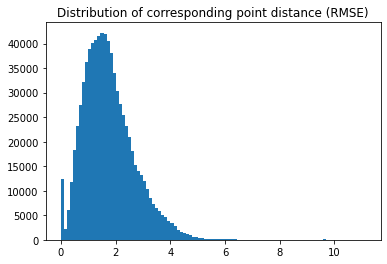

In [47]:
plt.hist(np.array(TestDataCorrePointDists).flatten(), bins=100)
plt.title("Distribution of corresponding point distance (RMSE)")
plt.show()

In [33]:
MuDataCorrePointDists = []

for mask,yi in zip(X_mask_tes,Y_pg_tes): 
    maskedMu = np.multiply(mask, Mu) # 使用牙列均值作为预测
    shiftMu = np.concatenate([maskedMu[:Mu.shape[0]//2, ...]+SHIFT_VEC, maskedMu[Mu.shape[0]//2:, ...]-SHIFT_VEC], axis=0)
    errors = computeCorrePointDistance(yi, shiftMu)
    MuDataCorrePointDists.append(errors)


MuDataCorrePointDists = np.array(MuDataCorrePointDists).flatten()
print("average corre point dist with Mu: {:.4f}mm".format(np.mean(MuDataCorrePointDists)))
print("average custom L2 loss with Mu: {:.4f}".format(np.mean(np.square(MuDataCorrePointDists))))

average corre point dist with Mu: 1.7559mm
average custom L2 loss with Mu: 4.0215


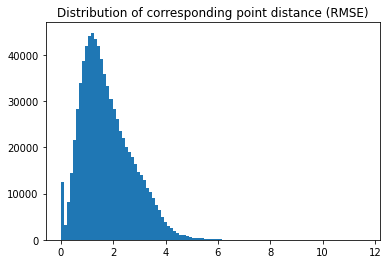

In [34]:
plt.hist(MuDataCorrePointDists, bins=100)
plt.title("Distribution of corresponding point distance (RMSE)")
plt.show()